# AI-based Audio Analysis of Music and Soundscapes

## Deep Learning 

## <font color='red'>Programming Session</font>

In [155]:
import glob
import os
import librosa
import tensorflow
from sklearn.metrics import accuracy_score, confusion_matrix

## Classifying animal sounds with a fully-connected deep neural network

We'll use the animal classification dataset from the lecture on **Machine Learning**

**Reminder**: The dataset used here is a manual selection of 5 examples for 5 animal classes from the https://github.com/karolpiczak/ESC-50 dataset.

Let's use the code from before to load the dataset...

In [178]:
import glob
dir_dataset = 'audio/animal_sounds'
sub_directories = glob.glob(os.path.join(dir_dataset, '*'))

n_sub = len(sub_directories)
# let's collect the files in each subdirectory
# the folder name is the class name
fn_wav_list = []
class_label = []
file_num_in_class = []

for i in range(n_sub):
    current_class_label = os.path.basename(sub_directories[i])
    current_fn_wav_list = sorted(glob.glob(os.path.join(sub_directories[i], '*.wav')))
    for k, fn_wav in enumerate(current_fn_wav_list):
        fn_wav_list.append(fn_wav)
        class_label.append(current_class_label)
        file_num_in_class.append(k)

n_files = len(class_label)
   
# this vector includes a "counter" for each file within its class, we use it later ...
file_num_in_class = np.array(file_num_in_class)

In [179]:
unique_classes = sorted(list(set(class_label)))
print("All unique class labels (sorted alphabetically)", unique_classes)
class_id = np.array([unique_classes.index(_) for _ in class_label])


All unique class labels (sorted alphabetically) ['cat', 'cow', 'dog', 'frog', 'insect']


### Feature Extraction

Instead of the MFCC features we used before, let's use the mel-spectrogram as "raw" input data.

Here's a useful function to compute a mel-spectrogram from a given audio file.

In [181]:
def compute_mel_spec_for_audio_file(fn_wav,
                                    n_fft=1024,  
                                    hop_length=441,
                                    fs=22050.,
                                    n_mels=64):
    """ Compute mel spectrogram
    Args:
        fn_wav (str): Audio file name
        n_fft (int): FFT size
        hop_length (int): Hop size in samples
        fs (float): Sample rate in Hz
        n_mels (int): Number of mel bands
    """
    # load audio samples
    x, fs = librosa.load(fn_wav, sr=fs, mono=True)

    # normalize to the audio file to an maximum absolute value of 1
    if np.max(np.abs(x)) > 0:
        x = x / np.max(np.abs(x))

    # mel-spectrogram
    X = librosa.feature.melspectrogram(y=x,
                                       sr=fs,
                                       n_fft=n_fft,
                                       hop_length=hop_length,
                                       n_mels=n_mels,
                                       fmin=0.0,
                                       fmax=fs / 2,
                                       power=1.0,
                                       htk=True,
                                       norm=None)

    # apply dB normalization
    X = librosa.amplitude_to_db(X)

    return X

Here's how this looks for the first file in our dataset:

Shape of Mel-spectrogram (64, 251)


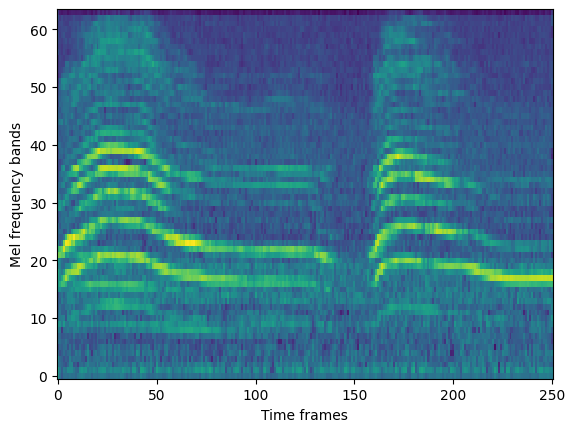

In [183]:
mel_spec = compute_mel_spec_for_audio_file(fn_wav_list[0])
print("Shape of Mel-spectrogram", mel_spec.shape)

pl.figure()
pl.imshow(mel_spec, origin="lower", aspect="auto", interpolation="None")
pl.ylabel('Mel frequency bands')
pl.xlabel('Time frames')
pl.show()

Let's do this over all files and compute all mel spectrograms (*this takes a couple of seconds to compute*)

In [184]:
all_mel_specs = []
for i, fn_wav in enumerate(fn_wav_list):
    all_mel_specs.append(compute_mel_spec_for_audio_file(fn_wav_list[i]))
    
print("We have {} spectrograms of shape {}".format(len(all_mel_specs), all_mel_specs[0].shape))

We have 25 spectrograms of shape (64, 251)


The final shape of each spectrogram is ```(64, 251)``` and covers 64 mel frequency bands and 251 time frames.

Now we want to do **three things**
1. Transpose each spectrogram (switch columns and rows) using the ```.T``` numpy function. The reason is that we want to use each time frame (column) in the spectrogram as individual feature vector. Threfore, we get multiple feature vectors from each file.
2. Collect all features vectors from all files. For this, we combine all transposed matrices to one large feature matrix by stacking them vertically below each other.
3. Create three vectors, which store for each feature vector the 
    1. file ID of the orignal file
    2. the class number of the original file
    3. the within-class number of the original file (e.g. 0 for the first example of its class, 1 for the second etc.)

#### Step 1: Transpose the spectrograms

In [185]:
# step 1: transpose all spectrograms (flip rows and columns) and store them in a list
all_mel_specs = [spec.T for spec in all_mel_specs]
# let's check the new size:
print(all_mel_specs[0].shape)  

(251, 64)


Great, now the energies at the 64 mel frequencies are our features and appear in the second dimension!

#### Step 2: Combine all feature matrices (transposed spectrograms) to one large feature matrix

In [186]:
# step 2:
feature_matrix = np.vstack(all_mel_specs)
print("Feature matrix shape: {}".format(feature_matrix.shape))

Feature matrix shape: (6275, 64)


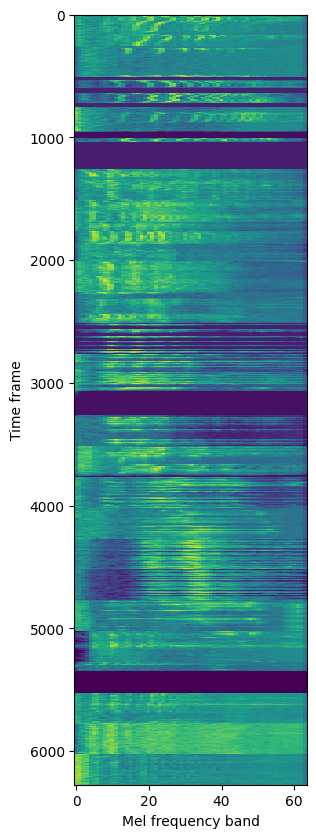

In [189]:
pl.figure(figsize=(3, 10))
pl.imshow(feature_matrix, aspect="auto", interpolation="None")
pl.ylabel('Time frame')
pl.xlabel('Mel frequency band')
pl.show()

**Observation**: Imaging this as a nice visual summary of our small dataset, we see all spectrogram examples for all files, sorted by classes from top to bottom.

**Note**: Due to the transposition step, you have to see it as a flipped spectrogram and now the x-axis carries the frequency information and the y-axis is the time axis.

#### Step 3: Create a vectors with the file-IDs for each row in the feature matrix and the class-IDs

In [190]:
n_files = len(all_mel_specs)

all_file_id = []
all_class_id = []
all_file_num_in_class = []

for cur_file_id in range(n_files):
    
    # how many time frames does this example have?
    cur_n_frames = all_mel_specs[cur_file_id].shape[0]
    
    # create a vector with file_ids (all the same for all frames of the current spectrogram)
    cur_file_id_vec = np.ones(cur_n_frames) * cur_file_id 
    
    # we'll do the same with the class ID associated with the current file
    cur_class_id = np.ones(cur_n_frames) * class_id[cur_file_id]
    
    # and again for the index of the file within each class (0 for the first example per class, 1 for the second ...)
    cur_file_num_in_class = np.ones(cur_n_frames) * file_num_in_class[cur_file_id]
    
    all_file_id.append(cur_file_id_vec)
    all_class_id.append(cur_class_id)
    all_file_num_in_class.append(cur_file_num_in_class)
        
# finally, let's concatenate them to two large arrayss
all_file_id = np.concatenate(all_file_id)
all_class_id = np.concatenate(all_class_id)
all_file_num_in_class = np.concatenate(all_file_num_in_class)


Let's visualize this for better understanding ...

Length of our file_id vector 0


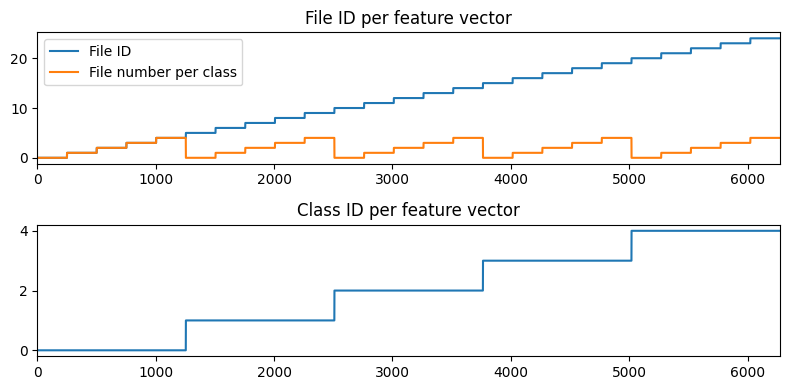

In [191]:
print("Length of our file_id vector", len(file_id))

pl.figure(figsize=(8,4))
pl.subplot(2,1,1)
pl.plot(all_file_id, label='File ID')
pl.plot(all_file_num_in_class, label='File number per class')
pl.title('File ID per feature vector')
pl.legend()
pl.xlabel('')
pl.xlim(0, len(all_file_id)-1)
pl.subplot(2,1,2)
pl.title('Class ID per feature vector')
pl.plot(all_class_id)
pl.xlim(0, len(all_class_id)-1)
pl.tight_layout()
pl.show()

**Obervation**: 

*Upper plot*: We can see that we have examples for every of the 25 audio files. The file number per class counts from 0 to 4 (first to 5th example per class) and the starts over again for each class.

*Bottom plot*: We can see that the class ID increases from 0 (first class) to 5 (last class)

### Dataset split into training and test set

We'll start with the code from the previous notebook. Again, we take the first three files per class as training data and the final two files as test data.

In [192]:
is_train = np.where(all_file_num_in_class <= 2)[0]
is_test = np.where(all_file_num_in_class >= 3)[0]

print("Our feature matrix is split into {} training examples and {} test examples".format(len(is_train), len(is_test)))

Our feature matrix is split into 3765 training examples and 2510 test examples


Now that we have splitted our dataset, we can generate the feature matrix and target vectors for the training and test set.

In [193]:
X_train = feature_matrix[is_train, :]
y_train = all_class_id[is_train]
X_test = feature_matrix[is_test, :]
y_test = all_class_id[is_test]

print("Let's look at the dimensions")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Let's look at the dimensions
(3765, 64)
(3765,)
(2510, 64)
(2510,)


Let's normalize our feature matrix first, this makes sure that all feature dimensions (columns in the feature matrix) have a mean of 0 and a standard deviation of 1. This makes it easier for the classifier.

In [194]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)

# apply the scaler also to the test set
X_test_norm = scaler.transform(X_test)

### One-hot encoding

Since we want to train a deep neural network, we need to encode the class labels (remember: 0 for the first class, 1 for the second class, 2 for the third class etc.) as binary vectors.

The idea is to create for each class label a vector of zeros with only one "1" value indicating the annotated class.

Example (for 5 classes:

```
class_id = 0
one_hot_vector = [1, 0, 0, 0, 0]

class_id = 2
one_hot_vector = [0, 0, 1, 0, 0]
```

Since we have multiple class IDs in ```all_class_ids```, we can use a useful function from *scikit-learn*:

In [195]:
from sklearn.preprocessing import OneHotEncoder
y_train_transformed = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_train.reshape(-1, 1))
y_test_transformed = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_test.reshape(-1, 1))

print("First four entries as class IDs:\n{}".format(y_train[:4]))
print("First four entries as one-hot-encoded vector:\n{}".format(y_train_transformed[:4, :]))

print("Shape of one-hot-encoded training targets: {}".format(y_train_transformed.shape))
print("Shape of one-hot-encoded test targets: {}".format(y_test_transformed.shape))


First four entries as class IDs:
[0. 0. 0. 0.]
First four entries as one-hot-encoded vector:
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Shape of one-hot-encoded training targets: (3765, 5)
Shape of one-hot-encoded test targets: (2510, 5)


### Fully-Connected Neural Network

#### Create Model

Let's build our neural network. We need the ```Dense``` layers, these are the fully-connected layers, we'll concatenate 3 of them as hidden layers and one as final output layer, which outputs the probabilities for different classes.

Between the ```Dense``` layers, we add ```Dropout``` layers. They are "regularizing" the model, that means that they randomly set some of the activations inside the network to zero during the model training. This makes the learning task more difficult for the network, at the same time the network learns a more robust model which better generalizes to unseen test data. You can try later to train the model without the dropout layers and compare the performance.

We furthermore use the ```Sequential``` model, which allows to easily add more layers to a network.
 

In [196]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential

# let's recall the dimension of our features:
n_input_dims = X_train_norm.shape[1]
print("Our input features have {} dimensions.".format(n_input_dims))

# ... and the number of classes:
n_classes = y_train_transformed.shape[1]
print("We want to classify between {} classes.".format(n_classes))

model = Sequential()
model.add(Dense(128, input_dim=n_input_dims, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu')) 
model.add(Dropout(.2))
model.add(Dense(64, activation='relu')) 

# let's add the final layer (output layer)
model.add(Dense(n_classes, activation="softmax"))
 
#model.compile(loss='mean_squared_error', optimizer='softmax', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
 
# Let's have a look on our model:
model.summary()

Our input features have 64 dimensions.
We want to classify between 5 classes.
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 128)               8320      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_54 (Dense)            (None, 64)                4160      
                                                                 
 dense_55 (Dense)            (None, 5)                 325       
                                         

#### Train model

Now we train the model over $40$ iterations using our training data.

In [197]:
history = model.fit(X_train_norm, y_train_transformed, epochs=40, batch_size=32, verbose=2)

Epoch 1/40
118/118 - 1s - loss: 0.8476 - accuracy: 0.6762 - 752ms/epoch - 6ms/step
Epoch 2/40
118/118 - 0s - loss: 0.3905 - accuracy: 0.8515 - 202ms/epoch - 2ms/step
Epoch 3/40
118/118 - 0s - loss: 0.3125 - accuracy: 0.8717 - 208ms/epoch - 2ms/step
Epoch 4/40
118/118 - 0s - loss: 0.2724 - accuracy: 0.8823 - 208ms/epoch - 2ms/step
Epoch 5/40
118/118 - 0s - loss: 0.2593 - accuracy: 0.8861 - 211ms/epoch - 2ms/step
Epoch 6/40
118/118 - 0s - loss: 0.2457 - accuracy: 0.8946 - 234ms/epoch - 2ms/step
Epoch 7/40
118/118 - 0s - loss: 0.2350 - accuracy: 0.9001 - 257ms/epoch - 2ms/step
Epoch 8/40
118/118 - 0s - loss: 0.2204 - accuracy: 0.9039 - 260ms/epoch - 2ms/step
Epoch 9/40
118/118 - 0s - loss: 0.2127 - accuracy: 0.9100 - 269ms/epoch - 2ms/step
Epoch 10/40
118/118 - 0s - loss: 0.2033 - accuracy: 0.9092 - 209ms/epoch - 2ms/step
Epoch 11/40
118/118 - 0s - loss: 0.1985 - accuracy: 0.9113 - 217ms/epoch - 2ms/step
Epoch 12/40
118/118 - 0s - loss: 0.1941 - accuracy: 0.9124 - 198ms/epoch - 2ms/step
E

**Observations**:

- We see that the **loss** value is decreasing and at the same time the **accuracy** is increasing, which show us that the model learns to classify the **training data** better and better over the first 40 epochs.

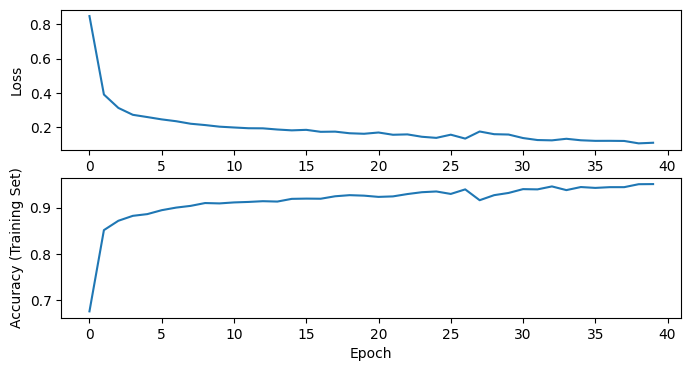

In [198]:
pl.figure(figsize=(8, 4))
pl.subplot(2,1,1)
pl.plot(history.history['loss'])
pl.ylabel('Loss')
pl.subplot(2,1,2)
pl.plot(history.history['accuracy'])
pl.ylabel('Accuracy (Training Set)')
pl.xlabel('Epoch')
pl.show()


#### Evaluate model

Now we evaluate the model using the **test data** and compute the **accuracy**.

In [199]:
y_test_pred = model.predict(X_test_norm)

print("Shape of the predictions: {}".format(y_test_pred.shape))

# The model outputs in each row 5 probability values (they always add to 1!) for each class. 
# We want take the class with the highest probability as prediction!

y_test_pred = np.argmax(y_test_pred, axis=1)
print("Shape of the predictions now: {}".format(y_test_pred.shape))

# Accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy score = ", accuracy)

79/79 [==============================] - 0s 996us/step
Shape of the predictions: (2510, 5)
Shape of the predictions now: (2510,)
Accuracy score =  0.6418326693227092


For the **evaluation**, we will compute the **accuracy** and the **confusion matrix**

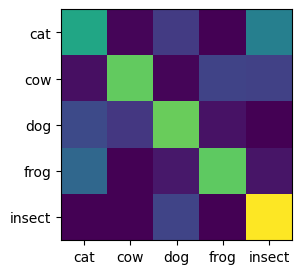

In [200]:
pl.figure(figsize=(3,3))
cm = confusion_matrix(y_test, y_test_pred).astype(np.float32)
# normalize to probabilities
for i in range(cm.shape[0]):
    if np.sum(cm[i, :]) > 0:
        cm[i, :] /= np.sum(cm[i, :])  # by dividing through the sum, we convert counts to probabilities
pl.imshow(cm)
ticks = np.arange(5)
pl.xticks(ticks, unique_classes)
pl.yticks(ticks, unique_classes)
pl.show()

**Observation**

This model reaches a very high accuracy on the training set (0.97) and a medium accuracy (around 0.6) on the test set. 

**Example: Let's try to understand our model better**

We'll take the last file as an example, it is part of the test set and assigned to the class "insects". Let's visualize the class probabilities frame-by-frame below the actual spectrogram...

In [202]:
x, fs = librosa.load(fn_wav_list[-1])
ipd.display(ipd.Audio(data=x, rate=fs))

8/8 [==============================] - 0s 2ms/step


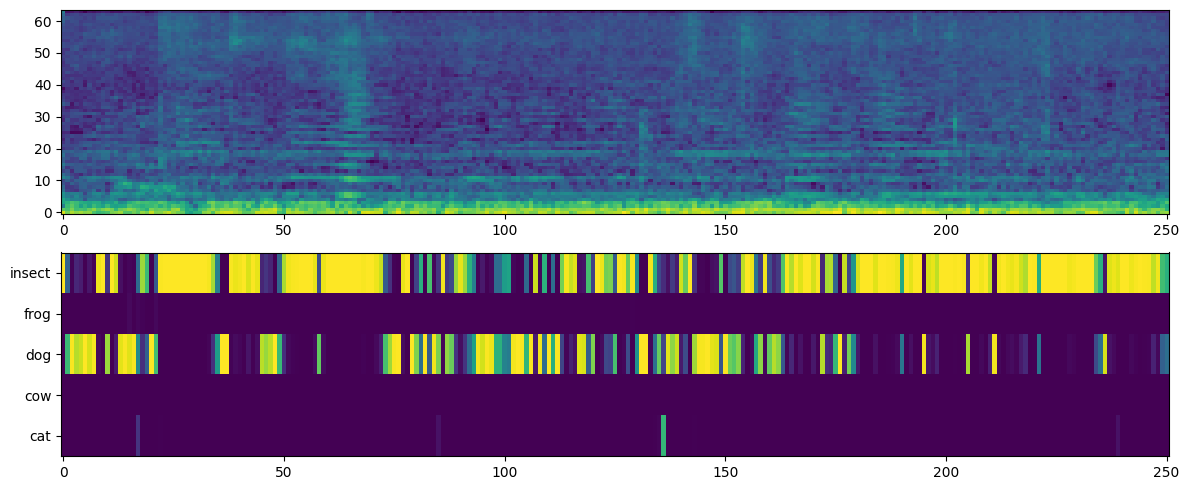

In [203]:
# extract the features
mel_spec = compute_mel_spec_for_audio_file(fn_wav_list[-1])

# transpose it to a feature matrix
feat_mat = mel_spec.T

# normalize the features
feat_mat = scaler.transform(feat_mat)

# compute model predictions
class_probs = model.predict(feat_mat)

# let's visualize the spectrogram and the predictions
pl.figure(figsize=(12, 5))
pl.subplot(2,1,1)
pl.imshow(mel_spec, origin="lower", aspect="auto", interpolation="None")
pl.subplot(2,1,2)
pl.imshow(class_probs.T, origin="lower", aspect="auto", interpolation="None")
pl.yticks(ticks, unique_classes)
pl.tight_layout()
pl.show()

**How to further improve this algorithm?**
  - for now, we computed the predictions **per frame**, we can easily aggregate them **to file-level classifications** by **averaging over the frame-level probabilies**
  - you can use the MFCC features instead of the mel spectrogram
  - try to increase the number of units in the dense layers (first parameter of ```Dense(...)```) or even add more hidden layers
  - try to train the model for a longer time (more epochs)
  - try another optimizer (see https://analyticsindiamag.com/guide-to-tensorflow-keras-optimizers/)